In [1]:
import torch
print(torch.version.cuda)               # Deve mostrar 12.1
print(torch.cuda.is_available())        # Deve ser True
print(torch.cuda.get_device_name(0))    # NVIDIA GeForce RTX 3050

12.1
True
NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [3]:
import torch
import torchvision
import os
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.data import DataLoader
import random
import os

SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [5]:
# Transformações para normalização e aumento de dados (caso necessário)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [7]:
# Diretórios de treino e validação
train_dir = "C:\\Users\\maste\\OneDrive\\Documentos\\Artigo_Rita_Dataset\\Training"
val_dir = "C:\\Users\\maste\\OneDrive\\Documentos\\Artigo_Rita_Dataset\\Validation"

def contar_imagens(diretorio):
    contador = 0
    for root, dirs, files in os.walk(diretorio):
        contador += len([f for f in files if f.endswith(('.png', '.jpg', '.jpeg'))])
    return contador

num_treino = contar_imagens(train_dir)
num_validacao = contar_imagens(val_dir)

print(f'Número de imagens no dataset de treino: {num_treino}')
print(f'Número de imagens no dataset de validação: {num_validacao}')

Número de imagens no dataset de treino: 684
Número de imagens no dataset de validação: 147


In [9]:
# Carregando datasets de treino e validação
train_data = datasets.ImageFolder(train_dir, transform=transform)
val_data = datasets.ImageFolder(val_dir, transform=transform)

In [11]:
# Criando dataloaders para iterar sobre os dados durante o treinamento
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [13]:
# Definindo as classes do dataset
classes = train_data.classes
classes2 = val_data.classes
print(classes)
print(classes2)

['malignant_tumor', 'no_tumor']
['malignant_tumor', 'no_tumor']


In [15]:
# Carregando o modelo Densenet pré-treinado
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

In [17]:
# Congelando as camadas iniciais e descongelando as camadas finais
for param in model.parameters():
    param.requires_grad = False
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, len(classes))
for param in model.classifier.parameters():
    param.requires_grad = True

In [23]:
# Definindo a função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [27]:
# Caminhos para salvar os pesos e o modelo
save_weights = "C:\\Users\\maste\\OneDrive\\Documentos\\Resultados_Redes_WVC2025\\DenseNet121\\50_epocas\\SGD\\melhor_modelo"
save_model = "C:\\Users\\maste\\OneDrive\\Documentos\\Resultados_Redes_WVC2025\\DenseNet121\\50_epocas\\SGD\\melhor_modelo\\melhor_modelo.pt"

In [29]:
model.to(device)
num_epochs=50
# Listas para armazenar perda e acurácia
train_loss_values = []
val_loss_values = []
train_accuracy_values = []
val_accuracy_values = []

# Listas para armazenar rótulos verdadeiros e predições para a matriz de confusão e curva ROC
all_labels = []
all_preds = []

# Treinamento e coleta de dados
best_accuracy = 0.0
counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit='batch'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total

    train_loss_values.append(epoch_loss)
    train_accuracy_values.append(train_accuracy)

    # Validação
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}", unit='batch'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader.dataset)
        val_accuracy = val_correct / val_total

        val_loss_values.append(val_loss)
        val_accuracy_values.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        # Verificar se a acurácia de validação melhorou e salvar o modelo
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            model_save_path = os.path.join(save_weights, f'model_epoch_{epoch+1}_val_accuracy_{val_accuracy:.4f}.pt')
            torch.save(model.state_dict(), model_save_path)
            print(f'Saved model at epoch {epoch+1} with validation accuracy: {val_accuracy:.4f} to {model_save_path}')

print('Treinamento finalizado')

# Salvar o modelo inteiro
torch.save(model, save_model)
print(f'Saved entire model at {save_model}')

Validation Epoch 1/50: 100%|██████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.32batch/s]


Epoch 1/50, Training Loss: 0.7001, Training Accuracy: 0.5395, Validation Loss: 0.6181, Validation Accuracy: 0.6327
Saved model at epoch 1 with validation accuracy: 0.6327 to C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\DenseNet121\50_epocas\SGD\melhor_modelo\model_epoch_1_val_accuracy_0.6327.pt


Validation Epoch 2/50: 100%|██████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.52batch/s]


Epoch 2/50, Training Loss: 0.5934, Training Accuracy: 0.7208, Validation Loss: 0.5411, Validation Accuracy: 0.8776
Saved model at epoch 2 with validation accuracy: 0.8776 to C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\DenseNet121\50_epocas\SGD\melhor_modelo\model_epoch_2_val_accuracy_0.8776.pt


Validation Epoch 3/50: 100%|██████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.46batch/s]


Epoch 3/50, Training Loss: 0.5067, Training Accuracy: 0.8012, Validation Loss: 0.4318, Validation Accuracy: 0.9116
Saved model at epoch 3 with validation accuracy: 0.9116 to C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\DenseNet121\50_epocas\SGD\melhor_modelo\model_epoch_3_val_accuracy_0.9116.pt


Validation Epoch 4/50: 100%|██████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.52batch/s]


Epoch 4/50, Training Loss: 0.4335, Training Accuracy: 0.8977, Validation Loss: 0.3713, Validation Accuracy: 0.9320
Saved model at epoch 4 with validation accuracy: 0.9320 to C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\DenseNet121\50_epocas\SGD\melhor_modelo\model_epoch_4_val_accuracy_0.9320.pt


Validation Epoch 5/50: 100%|██████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.49batch/s]


Epoch 5/50, Training Loss: 0.3883, Training Accuracy: 0.9050, Validation Loss: 0.3308, Validation Accuracy: 0.9456
Saved model at epoch 5 with validation accuracy: 0.9456 to C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\DenseNet121\50_epocas\SGD\melhor_modelo\model_epoch_5_val_accuracy_0.9456.pt


Validation Epoch 6/50: 100%|██████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.52batch/s]


Epoch 6/50, Training Loss: 0.3498, Training Accuracy: 0.9298, Validation Loss: 0.2999, Validation Accuracy: 0.9592
Saved model at epoch 6 with validation accuracy: 0.9592 to C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\DenseNet121\50_epocas\SGD\melhor_modelo\model_epoch_6_val_accuracy_0.9592.pt


Validation Epoch 7/50: 100%|██████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.42batch/s]


Epoch 7/50, Training Loss: 0.3156, Training Accuracy: 0.9444, Validation Loss: 0.2746, Validation Accuracy: 0.9660
Saved model at epoch 7 with validation accuracy: 0.9660 to C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\DenseNet121\50_epocas\SGD\melhor_modelo\model_epoch_7_val_accuracy_0.9660.pt


Validation Epoch 8/50: 100%|██████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.50batch/s]


Epoch 8/50, Training Loss: 0.2961, Training Accuracy: 0.9474, Validation Loss: 0.2560, Validation Accuracy: 0.9660


Validation Epoch 9/50: 100%|██████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.44batch/s]


Epoch 9/50, Training Loss: 0.2763, Training Accuracy: 0.9518, Validation Loss: 0.2382, Validation Accuracy: 0.9796
Saved model at epoch 9 with validation accuracy: 0.9796 to C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\DenseNet121\50_epocas\SGD\melhor_modelo\model_epoch_9_val_accuracy_0.9796.pt


Validation Epoch 10/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.49batch/s]


Epoch 10/50, Training Loss: 0.2522, Training Accuracy: 0.9591, Validation Loss: 0.2238, Validation Accuracy: 0.9660


Validation Epoch 11/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.49batch/s]


Epoch 11/50, Training Loss: 0.2565, Training Accuracy: 0.9532, Validation Loss: 0.2133, Validation Accuracy: 0.9864
Saved model at epoch 11 with validation accuracy: 0.9864 to C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\DenseNet121\50_epocas\SGD\melhor_modelo\model_epoch_11_val_accuracy_0.9864.pt


Validation Epoch 12/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.41batch/s]


Epoch 12/50, Training Loss: 0.2313, Training Accuracy: 0.9605, Validation Loss: 0.2020, Validation Accuracy: 0.9864


Validation Epoch 13/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.45batch/s]


Epoch 13/50, Training Loss: 0.2351, Training Accuracy: 0.9591, Validation Loss: 0.1942, Validation Accuracy: 0.9864


Validation Epoch 14/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.43batch/s]


Epoch 14/50, Training Loss: 0.2153, Training Accuracy: 0.9620, Validation Loss: 0.1836, Validation Accuracy: 0.9864


Validation Epoch 15/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.45batch/s]


Epoch 15/50, Training Loss: 0.2153, Training Accuracy: 0.9518, Validation Loss: 0.1785, Validation Accuracy: 0.9864


Validation Epoch 16/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.58batch/s]


Epoch 16/50, Training Loss: 0.1981, Training Accuracy: 0.9693, Validation Loss: 0.1695, Validation Accuracy: 0.9864


Validation Epoch 17/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.43batch/s]


Epoch 17/50, Training Loss: 0.1854, Training Accuracy: 0.9678, Validation Loss: 0.1651, Validation Accuracy: 0.9864


Validation Epoch 18/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.43batch/s]


Epoch 18/50, Training Loss: 0.1831, Training Accuracy: 0.9722, Validation Loss: 0.1664, Validation Accuracy: 0.9932
Saved model at epoch 18 with validation accuracy: 0.9932 to C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\DenseNet121\50_epocas\SGD\melhor_modelo\model_epoch_18_val_accuracy_0.9932.pt


Validation Epoch 19/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.28batch/s]


Epoch 19/50, Training Loss: 0.1791, Training Accuracy: 0.9678, Validation Loss: 0.1536, Validation Accuracy: 0.9864


Validation Epoch 20/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.06s/batch]


Epoch 20/50, Training Loss: 0.1716, Training Accuracy: 0.9708, Validation Loss: 0.1494, Validation Accuracy: 0.9864


Validation Epoch 21/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.04s/batch]


Epoch 21/50, Training Loss: 0.1635, Training Accuracy: 0.9737, Validation Loss: 0.1440, Validation Accuracy: 0.9864


Validation Epoch 22/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.08s/batch]


Epoch 22/50, Training Loss: 0.1729, Training Accuracy: 0.9649, Validation Loss: 0.1395, Validation Accuracy: 0.9864


Validation Epoch 23/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.49batch/s]


Epoch 23/50, Training Loss: 0.1623, Training Accuracy: 0.9708, Validation Loss: 0.1375, Validation Accuracy: 0.9864


Validation Epoch 24/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.38batch/s]


Epoch 24/50, Training Loss: 0.1654, Training Accuracy: 0.9693, Validation Loss: 0.1386, Validation Accuracy: 1.0000
Saved model at epoch 24 with validation accuracy: 1.0000 to C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\DenseNet121\50_epocas\SGD\melhor_modelo\model_epoch_24_val_accuracy_1.0000.pt


Validation Epoch 25/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.49batch/s]


Epoch 25/50, Training Loss: 0.1412, Training Accuracy: 0.9751, Validation Loss: 0.1345, Validation Accuracy: 0.9932


Validation Epoch 26/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.45batch/s]


Epoch 26/50, Training Loss: 0.1441, Training Accuracy: 0.9810, Validation Loss: 0.1297, Validation Accuracy: 0.9864


Validation Epoch 27/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.49batch/s]


Epoch 27/50, Training Loss: 0.1522, Training Accuracy: 0.9708, Validation Loss: 0.1287, Validation Accuracy: 1.0000


Validation Epoch 28/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.45batch/s]


Epoch 28/50, Training Loss: 0.1417, Training Accuracy: 0.9781, Validation Loss: 0.1269, Validation Accuracy: 1.0000


Validation Epoch 29/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.46batch/s]


Epoch 29/50, Training Loss: 0.1372, Training Accuracy: 0.9737, Validation Loss: 0.1278, Validation Accuracy: 1.0000


Validation Epoch 30/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.44batch/s]


Epoch 30/50, Training Loss: 0.1548, Training Accuracy: 0.9737, Validation Loss: 0.1190, Validation Accuracy: 1.0000


Validation Epoch 31/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.44batch/s]


Epoch 31/50, Training Loss: 0.1308, Training Accuracy: 0.9781, Validation Loss: 0.1190, Validation Accuracy: 1.0000


Validation Epoch 32/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.03s/batch]


Epoch 32/50, Training Loss: 0.1330, Training Accuracy: 0.9751, Validation Loss: 0.1152, Validation Accuracy: 0.9932


Validation Epoch 33/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.05s/batch]


Epoch 33/50, Training Loss: 0.1345, Training Accuracy: 0.9810, Validation Loss: 0.1256, Validation Accuracy: 0.9932


Validation Epoch 34/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.06s/batch]


Epoch 34/50, Training Loss: 0.1249, Training Accuracy: 0.9766, Validation Loss: 0.1111, Validation Accuracy: 0.9864


Validation Epoch 35/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03batch/s]


Epoch 35/50, Training Loss: 0.1239, Training Accuracy: 0.9795, Validation Loss: 0.1209, Validation Accuracy: 1.0000


Validation Epoch 36/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08batch/s]


Epoch 36/50, Training Loss: 0.1123, Training Accuracy: 0.9868, Validation Loss: 0.1119, Validation Accuracy: 1.0000


Validation Epoch 37/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.43batch/s]


Epoch 37/50, Training Loss: 0.1192, Training Accuracy: 0.9810, Validation Loss: 0.1132, Validation Accuracy: 1.0000


Validation Epoch 38/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11batch/s]


Epoch 38/50, Training Loss: 0.1197, Training Accuracy: 0.9766, Validation Loss: 0.1052, Validation Accuracy: 1.0000


Validation Epoch 39/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.54batch/s]


Epoch 39/50, Training Loss: 0.1162, Training Accuracy: 0.9708, Validation Loss: 0.1064, Validation Accuracy: 1.0000


Validation Epoch 40/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.25batch/s]


Epoch 40/50, Training Loss: 0.1106, Training Accuracy: 0.9825, Validation Loss: 0.1033, Validation Accuracy: 1.0000


Validation Epoch 41/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.26batch/s]


Epoch 41/50, Training Loss: 0.1170, Training Accuracy: 0.9766, Validation Loss: 0.1126, Validation Accuracy: 1.0000


Validation Epoch 42/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.34batch/s]


Epoch 42/50, Training Loss: 0.1091, Training Accuracy: 0.9839, Validation Loss: 0.1050, Validation Accuracy: 1.0000


Validation Epoch 43/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22batch/s]


Epoch 43/50, Training Loss: 0.1070, Training Accuracy: 0.9825, Validation Loss: 0.1018, Validation Accuracy: 1.0000


Validation Epoch 44/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08batch/s]


Epoch 44/50, Training Loss: 0.0989, Training Accuracy: 0.9883, Validation Loss: 0.1000, Validation Accuracy: 1.0000


Validation Epoch 45/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07batch/s]


Epoch 45/50, Training Loss: 0.1031, Training Accuracy: 0.9810, Validation Loss: 0.1081, Validation Accuracy: 1.0000


Validation Epoch 46/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07batch/s]


Epoch 46/50, Training Loss: 0.1035, Training Accuracy: 0.9795, Validation Loss: 0.0968, Validation Accuracy: 1.0000


Validation Epoch 47/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.40batch/s]


Epoch 47/50, Training Loss: 0.1084, Training Accuracy: 0.9751, Validation Loss: 0.0966, Validation Accuracy: 1.0000


Validation Epoch 48/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.24batch/s]


Epoch 48/50, Training Loss: 0.1067, Training Accuracy: 0.9737, Validation Loss: 0.0945, Validation Accuracy: 1.0000


Validation Epoch 49/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02batch/s]


Epoch 49/50, Training Loss: 0.0927, Training Accuracy: 0.9868, Validation Loss: 0.1009, Validation Accuracy: 1.0000


Validation Epoch 50/50: 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.52batch/s]


Epoch 50/50, Training Loss: 0.0974, Training Accuracy: 0.9839, Validation Loss: 0.1011, Validation Accuracy: 1.0000
Treinamento finalizado
Saved entire model at C:\Users\maste\OneDrive\Documentos\Resultados_Redes_WVC2025\DenseNet121\50_epocas\SGD\melhor_modelo\melhor_modelo.pt


In [31]:
# Confirmação do carregamento do modelo e dos pesos
model.to(device)

model.eval()
confirmation_correct = 0
confirmation_total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        confirmation_total += labels.size(0)
        confirmation_correct += (predicted == labels).sum().item()

print(f'Confirmation Accuracy: { confirmation_correct / confirmation_total:.4f}')

Confirmation Accuracy: 1.0000


In [33]:
# Avaliando o modelo carregado no conjunto de teste
model.eval()
test_running_loss = 0.0
test_correct = 0
test_total = 0

all_labels = []
all_probs = []  # Para armazenar as probabilidades

with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Val"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        #loss = nn.CrossEntropyLoss()(outputs, labels)
        #test_running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

        # Armazenando rótulos e probabilidades
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    val_loss = val_running_loss / len(val_loader.dataset)
    val_accuracy = val_correct / val_total
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Val: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.42it/s]

Val Loss: 0.1011, Val Accuracy: 1.0000


In [35]:
# Calculando a matriz de confusão
cm = confusion_matrix(all_labels, np.argmax(all_probs, axis=1))

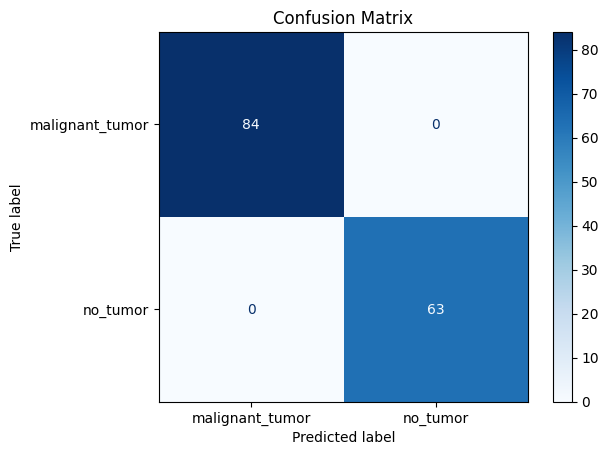

In [37]:
# Plotando a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig("C:\\Users\\maste\\OneDrive\\Documentos\\Resultados_Redes_WVC2025\\DenseNet121\\50_epocas\\SGD\\gráficos\\treino\\matriz_validacao.pdf")
plt.show()

In [39]:
import torch
from sklearn.metrics import classification_report
#from  utils import to_onehot
# Alterar o modelo para o modo de avaliação
model.eval()

# Para armazenar rótulos verdadeiros e previsões
all_labels = []
all_preds = []

# Desabilitar cálculo de gradiente para inferência
with torch.no_grad():
    for data in val_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Obter saídas do modelo e prever a classe
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Armazenar rótulos e previsões
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
#all_preds = utils.to_onehot(all_probs, 1)
# Gerar relatório de classificação
target_names = ['Bom', 'Ruim']
print(classification_report(all_labels, all_preds, target_names=target_names))
print(outputs)
print(preds)
print(all_preds)

              precision    recall  f1-score   support

         Bom       1.00      1.00      1.00        84
        Ruim       1.00      1.00      1.00        63

    accuracy                           1.00       147
   macro avg       1.00      1.00      1.00       147
weighted avg       1.00      1.00      1.00       147

tensor([[-1.5220,  0.8119],
        [-2.2461,  1.6952],
        [-1.0619,  0.9047],
        [-1.3756,  0.7796],
        [-1.8064,  0.7359],
        [-1.7850,  0.9786],
        [-2.2420,  1.6408],
        [-1.6572,  1.2563],
        [-3.1766,  2.2405],
        [-3.0828,  2.7547],
        [-1.8739,  1.8147],
        [-2.6135,  1.9220],
        [-1.4156,  0.8338],
        [-1.4476,  0.5274],
        [-1.8050,  0.4403],
        [-1.9967,  1.6739],
        [-0.5979, -0.0304],
        [-2.1499,  2.2049],
        [-1.5986,  1.4790]], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
[np.int64(0), np.int64(0), np.int

In [41]:
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
#y_pred_keras = keras_model.predict(X_test).ravel()


classes = val_data.classes
num_classes = len(classes)

all_labels = np.array(all_labels)
all_preds = np.array( all_preds)

fpr, tpr, _ = roc_curve(all_labels , all_preds)

print(fpr)
print('---------')
print(tpr)
print('---------')




#for i in range(num_classes):
#    # Calculando a ROC para a classe i
#    fpr, tpr, _ = roc_curve(all_labels == i, all_preds[:, i])
#    roc_auc = auc(fpr, tpr)
#    plt.plot(fpr, tpr, label=f'Classe {classes[i]} (AUC = {roc_auc:.2f})')

[0. 0. 1.]
---------
[0. 1. 1.]
---------


In [43]:
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)
print(auc_keras)

1.0


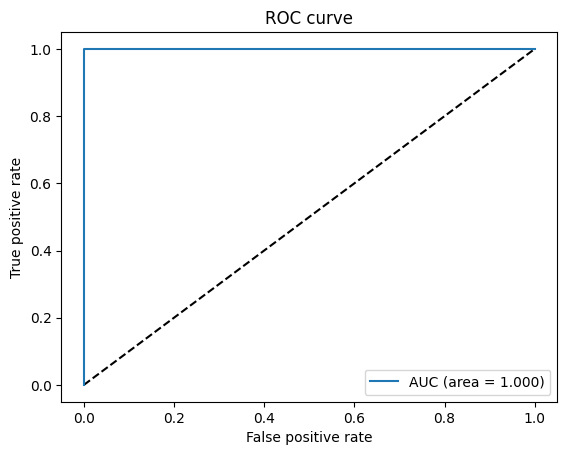

In [45]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig("C:\\Users\\maste\\OneDrive\\Documentos\\Resultados_Redes_WVC2025\\DenseNet121\\50_epocas\\SGD\\gráficos\\treino\\CurvaRoc_treino.pdf")
plt.show()

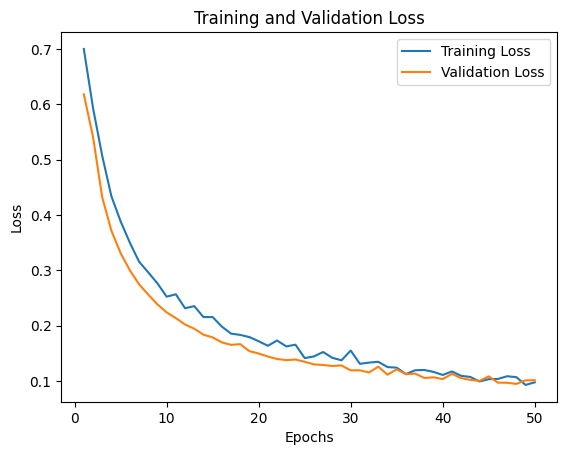

In [47]:
# Plotando a perda
epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, train_loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig("C:\\Users\\maste\\OneDrive\\Documentos\\Resultados_Redes_WVC2025\\DenseNet121\\50_epocas\\SGD\\gráficos\\treino\\Loss_treino.pdf")
plt.show()

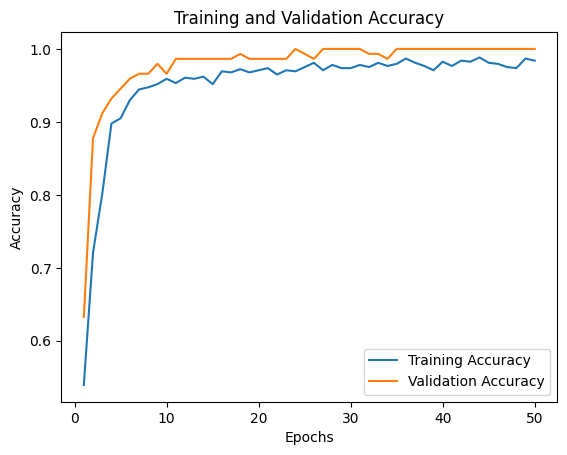

In [49]:
# Plotando a acurácia
plt.figure()
plt.plot(epochs, train_accuracy_values, label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig("C:\\Users\\maste\\OneDrive\\Documentos\\Resultados_Redes_WVC2025\\DenseNet121\\50_epocas\\SGD\\gráficos\\treino\\Accuracy_treino.pdf")
plt.show()

In [51]:
test_dir = "C:\\Users\\maste\\OneDrive\\Documentos\\Artigo_Rita_Dataset\\Testing"

In [53]:
# Transformações para normalização e aumento de dados
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [55]:
test_data = datasets.ImageFolder(test_dir, transform=transform)

In [57]:
# Criando o DataLoader para o conjunto de teste
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

In [59]:
# Definindo as classes do dataset
classes = test_data.classes
num_classes = len(classes)
print(num_classes)
print(classes)

2
['malignant_tumor', 'no_tumor']


In [61]:
# Avaliando o modelo carregado no conjunto de teste
model.eval()
test_running_loss = 0.0
test_correct = 0
test_total = 0

all_labels = []
all_probs = []  # Para armazenar as probabilidades

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Test"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        #loss = nn.CrossEntropyLoss()(outputs, labels)
        #test_running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        # Armazenando rótulos e probabilidades
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    test_loss = val_running_loss / len(test_loader.dataset)
    test_accuracy = test_correct / test_total
    print(f'Val Loss: {test_loss:.4f}, Val Accuracy: {test_accuracy:.4f}')

Test: 100%|██████████████████████████████████████████████████████████████████████████| 146/146 [00:17<00:00,  8.23it/s]

Val Loss: 0.1018, Val Accuracy: 0.9110


In [63]:
# Calculando a matriz de confusão
cm = confusion_matrix(all_labels, np.argmax(all_probs, axis=1))

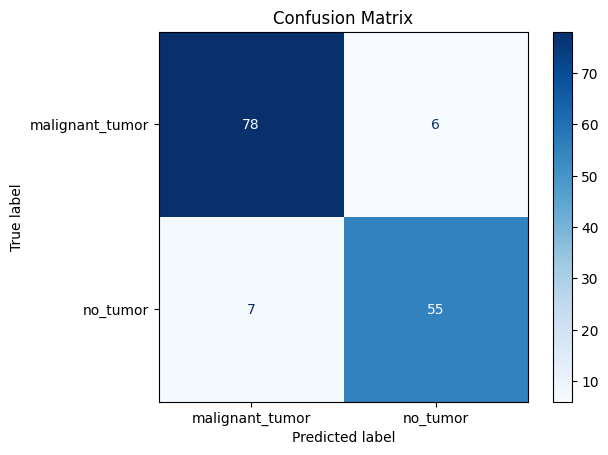

In [65]:
# Plotando a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig("C:\\Users\\maste\\OneDrive\\Documentos\\Resultados_Redes_WVC2025\DenseNet121\\50_epocas\\SGD\\gráficos\\validação\\Matriz_validação.pdf")
plt.show()

In [67]:
import torch
from sklearn.metrics import classification_report
#from  utils import to_onehot
# Alterar o modelo para o modo de avaliação
model.eval()

# Para armazenar rótulos verdadeiros e previsões
all_labels = []
all_preds = []

# Desabilitar cálculo de gradiente para inferência
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Obter saídas do modelo e prever a classe
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Armazenar rótulos e previsões
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
#all_preds = utils.to_onehot(all_probs, 1)
# Gerar relatório de classificação
target_names = ['Câncer', 'Normal']
print(classification_report(all_labels, all_preds, target_names=target_names))
print(outputs)
print(preds)
print(all_preds)

              precision    recall  f1-score   support

      Câncer       0.92      0.93      0.92        84
      Normal       0.90      0.89      0.89        62

    accuracy                           0.91       146
   macro avg       0.91      0.91      0.91       146
weighted avg       0.91      0.91      0.91       146

tensor([[-1.4652,  1.3931]], device='cuda:0')
tensor([1], device='cuda:0')
[np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1),

In [69]:
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
#y_pred_keras = keras_model.predict(X_test).ravel()


classes = test_data.classes
num_classes = len(classes)

all_labels = np.array(all_labels)
all_preds = np.array( all_preds)

fpr, tpr, _ = roc_curve(all_labels , all_preds)

print(fpr)
print('---------')
print(tpr)
print('---------')




#for i in range(num_classes):
#    # Calculando a ROC para a classe i
#    fpr, tpr, _ = roc_curve(all_labels == i, all_preds[:, i])
#    roc_auc = auc(fpr, tpr)
#    plt.plot(fpr, tpr, label=f'Classe {classes[i]} (AUC = {roc_auc:.2f})')

[0.         0.07142857 1.        ]
---------
[0.         0.88709677 1.        ]
---------


In [71]:
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)
print(auc_keras)

0.9078341013824885


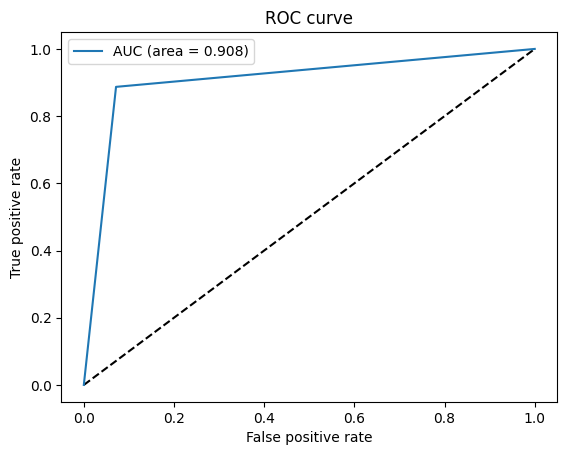

In [73]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig("C:\\Users\\maste\\OneDrive\\Documentos\\Resultados_Redes_WVC2025\DenseNet121\\50_epocas\\SGD\\gráficos\\validação\\CurvaRoc_validação.pdf")
plt.show()

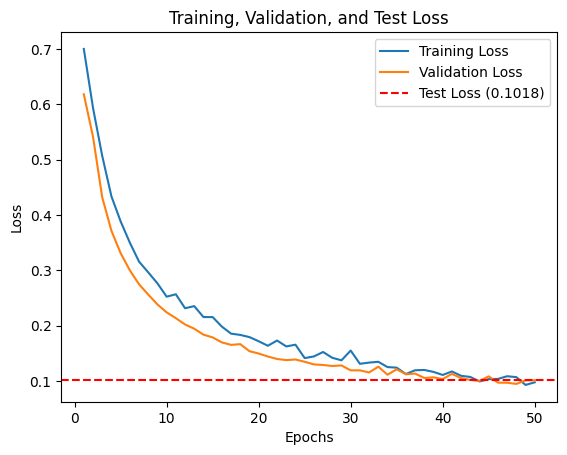

In [81]:
plt.figure()
plt.plot(epochs, train_loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')

# Linha horizontal com o valor do teste
plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test Loss ({test_loss:.4f})')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.savefig("C:\\Users\\maste\\OneDrive\\Documentos\\Resultados_Redes_WVC2025\\DenseNet121\\50_epocas\\SGD\\gráficos\\validação\\Loss_teste.pdf")
plt.show()


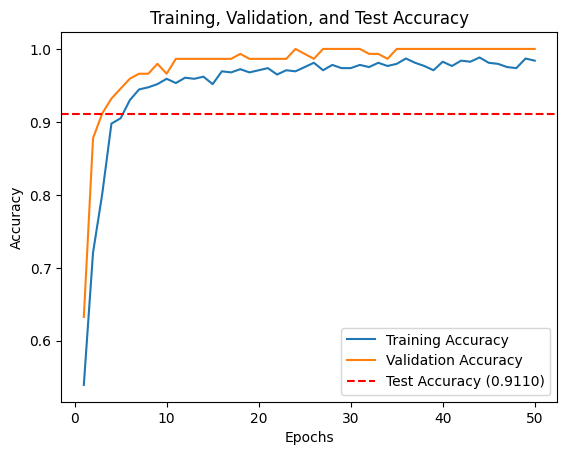

In [85]:
plt.figure()
plt.plot(epochs, train_accuracy_values, label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, label='Validation Accuracy')

# Linha horizontal para o teste
plt.axhline(y=test_accuracy, color='r', linestyle='--', 
            label=f'Test Accuracy ({test_accuracy:.4f})')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.savefig("C:\\Users\\maste\\OneDrive\\Documentos\\Resultados_Redes_WVC2025\\DenseNet121\\50_epocas\\SGD\\gráficos\\validação\\Accuracy_teste.pdf")
plt.show()
